# <font color='green'>Majority vote vs parity checks</font>

In the previous chapter, we used majority voting to interpret the message that was received across a noisy channel using the repetition code. The general procedure was as follows:

```
- Create multiple copies of the bit that we want to send
- Transmit those bits
- Receive those bits, with some error. Then look at all of them and take a majority vote of what we have seen.
```

We cannot directly apply this scheme to the quantum setting because it is incompatible with quantum mechanics in two ways. First, the no-cloning theorem (see [Wootters and Zurek (1982)](https://www.nature.com/articles/299802a0)) tells us that we cannot create copies of an arbitrary quantum state. Second, measuring a quantum state generally alters the state itself.

That quantum error correction is even possible with these restrictions is surprising in itself. There are two key ingredients that enable error correction in the quantum setting -- the first is switching from majority voting to parity checking. In this chapter, we will show that the two achieve the same results, while parity-checking avoids directly measuring individual bits. Then, the second ingredient -- the use of stabilizers -- describes how we do sets of parity checks to identify the specific kinds of errors that appear in the quantum setting and will be discussed in the next chapter.

## <font color='blue'>Implementing parity checks</font>

A parity check is simply the answer to the question, _"Are these things identical?"_ In our work, we will use a bitwise parity check, which means asking the question, _"Are these two bits both 0 or both 1?"_ You may recall that the exclusive-OR(`XOR`) operation answers this question directly -- the `XOR` between two bits is `0` if they are identical, or `1` if they are different.

We will now change our procedure for error correction to the following:

```
- Encode the information (classically, we can create copies)
- Transmit the information
- Check syndromes: upon receipt, do pairwise parity checks across the entire chain of bits
- Decode the syndromes to determine where errors have occurred
- Apply the necessary corrections at the error locations
- Unencode the message after corrections (classically, just do a full bitwise AND across all bits)
- Check that the unencoded message matches the transmitted one. When it wasn't, count that as an error
```

In this new procedure, we are never looking at any individual received bit on its own. Instead, we are running bitwise parity checks across the length of the message and recording these bits. The outcomes of these parity checks are known as _syndromes_. These syndromes capture locations where two consecutive bits are not the same. (Incidentally, it turns out that such a scheme is compatible with quantum mechanics, as we will see in the next chapter.)

Once we have the list of syndromes as the outcomes of doing several pairwise `XOR`s, we _decode_ where individual errors have occurred by using a clever system known as a `decoder`. The decoder takes in syndromes and outputs error locations. Once the decoder tells us which bits have errors, then we will flip those bits without ever seeing them.

Finally, in the spirit of never seeing any individual bit in the received message, we will unencode all of the (corrected) bits by doing a full bitwise `AND` across all of them. The end result is one bit of information, which we will then compare with the initially intended message to determine whether the entire procedure was successful.

## <font color='blue'>Implementing a 1D decoder</font>

The simplest decoder that we can implement is the 1D minimum-weight perfect matching decoder. Later in the textbook, you will see a formal definition of the minimum-weight perfect-matching problem as a solution whose input is a graph with edges and vertices. For now, the simplest implementation of the algorithm is:

```
option 1: assume data bit 0 had no error
from left to right, for each parity check bit indexed i >= 0
    error on data bit i + 1 = error on data bit i XOR parity check bit i

option 2: assume data bit 0 had an error
from left to right, for each parity check bit indexed i >= 0
    error on data bit i + 1 = error on data bit i XOR parity check bit i

compare options 1 and 2, and pick the one that has fewer errors (minimum weight)
```

This scheme is entirely applicable in the quantum setting, and can be used with qubits arranged in a line. The action of this decoder is described visually in the animation below.

![](../ch6-decoder-library/images/MWPM1D.gif)

In [1]:
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plotter
plotter.rcParams['font.family'] = 'Monospace'

First, we will create the functions for encoding, sending and receiving bits across the channel. Then, we will get the syndromes from the received bits by doing parity checks.

In [2]:
def encode(bit, num_copies):
    return [bit] * num_copies

def send(bits, p_error = 0.1):
    return [1^bit if random.random() <= p_error else bit for bit in bits]

def receive_and_get_syndromes(bits):
    syndromes = []
    for i in range(len(bits)-1):
        syndromes.append(bits[i] ^ bits[i+1]) # XOR(bits[i], bits[i+1])
    return syndromes

Then, we implement a 1D decoder as described above.

In [3]:
def count_from_left(syndromes, start_with_error):
    
    # if we know whether bit i has an error, and we know
    # parity[i], we can determine if bit i+1 has an error.
    #   -  -  -  -  -..  -   -..    -   -
    #  b0 b1 b2 b3 b4.. bi bi+1.. bn-1 bn
    #    p0 p1 p2 p3..    pi..      pn-1
    
    errors = []
    # Track whether current bit has an error
    current_bit_has_error = start_with_error
    if current_bit_has_error:
        errors.append(0)
    
    # Propagate through the chain
    for i in range(len(syndromes)):
        next_bit_has_error = current_bit_has_error ^ syndromes[i] 
        if next_bit_has_error:
            errors.append(i + 1)
        current_bit_has_error = next_bit_has_error
        
    return errors

def decode(syndromes):
    # Count errors from the left, assuming no error on bit 1
    errors_from_left_noerror0 = count_from_left(syndromes, start_with_error=False)
    # Count errors from the left, assuming yes error on bit 1
    errors_from_left_error0 = count_from_left(syndromes, start_with_error=True)

    # Choose the count with fewer errors
    if len(errors_from_left_noerror0) <= len(errors_from_left_error0):
        return sorted(errors_from_left_noerror0)
    else:
        return sorted(errors_from_left_error0)

Then, we can take the resulting error locations from the decoder and apply the necessary corrections by flipping those received bits.

In [4]:
def apply_corrections(received_bits, error_locations):
    
    corrected_bits = received_bits.copy()
    for error_location in error_locations:
        corrected_bits[error_location] = 1 - corrected_bits[error_location]
    return corrected_bits

And finally, we can unencode the bits after corrections have been applied.

In [5]:
def unencode(corrected_bits):

    unencoded_bit = None
    for i in range(len(corrected_bits)-1):
        if i == 0:
            unencoded_bit = corrected_bits[0] & corrected_bits[1]
        else:
            unencoded_bit &= corrected_bits[i+1]            
    return unencoded_bit

## <font color='blue'>Putting it all together</font>

Now, we combine all the steps together in a function to measure the error probability of a specific `code_distance` with a specific value of `p_error`. Then, we can write a loop to iterate over both of these parameters.

In [6]:
def get_code_error_probability(code_distance, p_error, n_shots = 1000):

    code_errors = 0.0
    for _ in range(n_shots):
        desired_message = random.choice([0,1])

        encoded_message = encode(desired_message, num_copies = code_distance)
        received_message = send(encoded_message, p_error = p_error)
        syndromes = receive_and_get_syndromes(received_message)
        error_locations = decode(syndromes)
        corrected_received_message = apply_corrections(received_message, error_locations)
        unencoded_message = unencode(corrected_received_message)
        
        if unencoded_message != desired_message:
            code_errors += 1

    return code_errors / n_shots

In [7]:
code_distances = np.arange(start = 3, stop = 13, step = 2)
p_errors = np.logspace(start = -3, stop = 0, num = 50)

all_code_distance_error_probabilities = []
for code_distance in code_distances:
    print(f"Running distance {code_distance}")
    code_distance_error_probabilities = []
    for p_error in p_errors:
        code_distance_error_probabilities.append(
            get_code_error_probability(code_distance, p_error, n_shots = 100000)
        )
    all_code_distance_error_probabilities.append(code_distance_error_probabilities)

Running distance 3
Running distance 5
Running distance 7
Running distance 9
Running distance 11


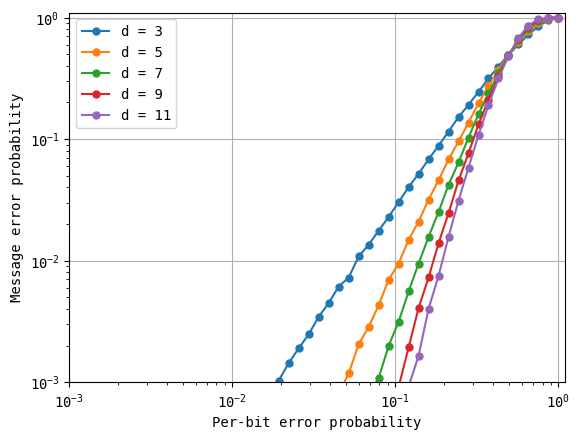

In [8]:
for code_distance, error_probabilities in zip(code_distances, all_code_distance_error_probabilities):
    plotter.loglog(p_errors, error_probabilities, marker = '.', markersize = 10, label=f'd = {code_distance}')
plotter.legend()
plotter.xlabel('Per-bit error probability')
plotter.ylabel('Message error probability')
plotter.xlim([1e-3, 1.1])
plotter.ylim([1e-3, 1.1])
plotter.grid()
plotter.show()

These are exactly the results that we saw with majority voting. We can convince ourselves that they are identical by plotting them together.

## <font color='blue'>Comparing the performance of majority voting with parity checking</font>

We reproduce the majority voting scheme from the previous chapter below and run it for the same parameters above.

In [9]:
def encode(bit, num_copies):
    return [bit] * num_copies

def send(bits, p_error = 0.1):
    return [1^bit if random.random() <= p_error else bit for bit in bits]

def receive_and_interpret(bits, majority_vote = False):
    received_bits_counted = Counter(bits).most_common()
    if majority_vote:
        return received_bits_counted[0][0]
    else:
        return received_bits_counted

def get_code_error_probability_mv(code_distance, p_error, n_shots = 1000):

    code_errors = 0.0
    for _ in range(n_shots):
        desired_message = random.choice([0,1])

        encoded_message = encode(desired_message, num_copies = code_distance)
        sent_message = send(encoded_message, p_error = p_error)
        received_message = receive_and_interpret(sent_message, majority_vote = True)

        if received_message != desired_message:
            code_errors += 1

    return code_errors / n_shots

all_code_distance_error_probabilities_mv = []
for code_distance in code_distances:
    print(f"Running distance {code_distance}")
    code_distance_error_probabilities = []
    for p_error in p_errors:
        code_distance_error_probabilities.append(
            get_code_error_probability_mv(code_distance, p_error, n_shots = 100000)
        )
    all_code_distance_error_probabilities_mv.append(code_distance_error_probabilities)

Running distance 3
Running distance 5
Running distance 7
Running distance 9
Running distance 11


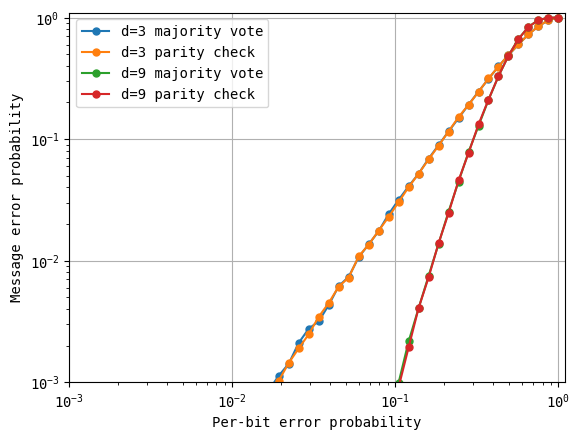

In [10]:
code_distances_to_plot_together = [0, 3]

for code_distance_index in code_distances_to_plot_together:
    error_probabilities_mv = all_code_distance_error_probabilities_mv[code_distance_index]
    error_probabilities_pc = all_code_distance_error_probabilities[code_distance_index]
    plotter.loglog(p_errors, error_probabilities_mv, marker = '.', markersize = 10, label=f'd={code_distances[code_distance_index]} majority vote')
    plotter.loglog(p_errors, error_probabilities_pc, marker = '.', markersize = 10, label=f'd={code_distances[code_distance_index]} parity check')
    
plotter.legend()
plotter.xlabel('Per-bit error probability')
plotter.ylabel('Message error probability')
plotter.xlim([1e-3, 1.1])
plotter.ylim([1e-3, 1.1])
plotter.grid()
plotter.show()

As you can see, the curves measured from majority voting and parity checking are overlapping. In the next section, we will take our learnings from classical repetition codes (the effect of increasing the code distance and the presence of a threshold) and use parity checks to extend into the quantum error correction setting.

---
### Version History
- v0: Sep 12, 2025, [github/@aasfaw](https:github.com/aasfaw)
- v1: Sep 16, 2025, [github/@aasfaw](https:github.com/aasfaw) edits capturing feedback from Earl Campbell
- v2: Sep 16, 2025, [github/@aasfaw](https:github.com/aasfaw) edits capturing feedback from Ophelia Crawford